# Understanding Logistic Regression

## Goal: Predict Flight Cancellations

In this notebook, we use logistic regression to predict whether a flight will be cancelled.

## 1. Load and Explore Data

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
url = "https://raw.githubusercontent.com/kjmobile/data/main/ml/flights_50k.csv"
df = pd.read_csv(url)

print(f"Data shape: {df.shape}")
print(f"\nCancellation rate:")
print(df['CANCELLED'].value_counts(normalize=True))

Data shape: (50000, 31)

Cancellation rate:
CANCELLED
0    0.98456
1    0.01544
Name: proportion, dtype: float64


## 2. Prepare Data

Select simple features for logistic regression.

**Important Notes:**
- We exclude `DEPARTURE_DELAY` to avoid **data leakage** (we can't know delays before the flight)
- Cancelled flights have missing `DEPARTURE_DELAY` values (they never departed)
- This is an **imbalanced dataset** (~1.5% cancellations)

In [37]:
df.head(2)

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015     10   29            4      EV           2851      N667GB   
1  2015      8   17            1      UA           1949      N36280   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0          12951               11298                 1040  ...        1205.0   
1            SEA                 ORD                   42  ...         732.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0           -8.0         0          0                  NaN               NaN   
1           52.0         0          0                  NaN               0.0   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
0             NaN            NaN                  NaN            NaN  
1             0.0            5.0                 47.0            0.0  

[2 rows x 31 columns]

In [36]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [38]:
# Select relevant columns (excluding DEPARTURE_DELAY to avoid data leakage)
columns_to_use = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'DISTANCE', 
                  'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'CANCELLED']


df_clean = df[columns_to_use].copy()

# Remove missing values
df_clean = df_clean.dropna()

# Encode AIRLINE as numeric
df_clean['AIRLINE_CODE'] = pd.Categorical(df_clean['AIRLINE']).codes
df_clean['ORIGIN_CODE'] = pd.Categorical(df_clean['ORIGIN_AIRPORT']).codes
df_clean['DEST_CODE'] = pd.Categorical(df_clean['DESTINATION_AIRPORT']).codes
df_clean['DEPARTURE_HOUR'] = df_clean['SCHEDULED_DEPARTURE'] // 100

print(f"Clean data shape: {df_clean.shape}")
print(f"Cancellations: {df_clean['CANCELLED'].sum()} ({df_clean['CANCELLED'].mean():.2%})")
df_clean.head()

Clean data shape: (50000, 13)
Cancellations: 772 (1.54%)


MONTH  DAY  DAY_OF_WEEK AIRLINE  DISTANCE ORIGIN_AIRPORT  \
0     10   29            4      EV       351          12951   
1      8   17            1      UA      1721            SEA   
2     11   12            4      OO       599            SLC   
3      4   30            4      EV        74            LAN   
4      9   10            4      B6      2446            JFK   

  DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  CANCELLED  AIRLINE_CODE  \
0               11298                 1040          0             4   
1                 ORD                   42          0            10   
2                 SFO                  835          0             9   
3                 DTW                 1340          0             4   
4                 SAN                 1659          0             2   

   ORIGIN_CODE  DEST_CODE  DEPARTURE_HOUR  
0          124         60              10  
1          502        454               0  
2          511        504               8  
3          399        323              13  
4          393        494              16

## 3. Separate Features (X) and Target (y)

In [43]:
# Select features (no DEPARTURE_DELAY - we can't know this before the flight)
features = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE_CODE', 'DISTANCE', 'ORIGIN_CODE', 'DEST_CODE', 'DEPARTURE_HOUR']
X = df_clean[features]
y = df_clean['CANCELLED']

print(y)
X.head(2)

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: CANCELLED, Length: 50000, dtype: int64


MONTH  DAY_OF_WEEK  AIRLINE_CODE  DISTANCE  ORIGIN_CODE  DEST_CODE  \
0     10            4             4       351          124         60   
1      8            1            10      1721          502        454   

   DEPARTURE_HOUR  
0              10  
1               0

## 4. Split Train/Test Data

In [45]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Training data: (40000, 7)
Test data: (10000, 7)


## 5. Train Logistic Regression Model

Logistic regression is an algorithm for binary classification (0 or 1).

We use `class_weight='balanced'` to handle the imbalanced dataset by giving more weight to the minority class (cancellations).

In [46]:
# Create and train model with balanced class weights
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


## 6. Predict and Evaluate

In [47]:
# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Cancelled', 'Cancelled']))

Accuracy: 0.5852

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      0.58      0.74      9846
    Cancelled       0.02      0.64      0.05       154

     accuracy                           0.59     10000
    macro avg       0.51      0.61      0.39     10000
 weighted avg       0.98      0.59      0.72     10000



## 7. Visualize Confusion Matrix

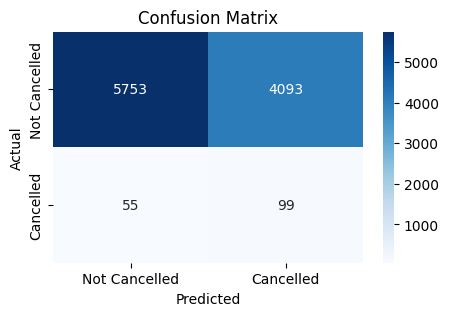

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## 8. Check Feature Importance

Examine coefficients to see which features are important for predicting cancellations.

          Feature  Coefficient
6  DEPARTURE_HOUR     0.020057
5       DEST_CODE     0.001058
4     ORIGIN_CODE     0.000375
3        DISTANCE    -0.000457
2    AIRLINE_CODE    -0.007187
1     DAY_OF_WEEK    -0.097205
0           MONTH    -0.109564


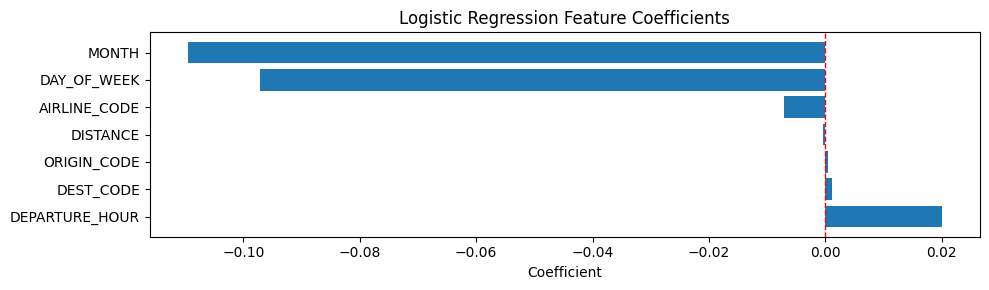

In [49]:
# Feature coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

print(coefficients)

# Visualize
plt.figure(figsize=(10,3))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Logistic Regression Feature Coefficients')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

## 9. Probability Predictions

Logistic regression can predict probabilities, not just 0 or 1.

In [50]:
# Predict probabilities (first 10 samples)
y_prob = model.predict_proba(X_test)[:10]

prob_df = pd.DataFrame({
    'Prob_Not_Cancelled': y_prob[:, 0],
    'Prob_Cancelled': y_prob[:, 1],
    'Predicted': y_pred[:10],
    'Actual': y_test.values[:10]
})

prob_df

Prob_Not_Cancelled  Prob_Cancelled  Predicted  Actual
0            0.620760        0.379240          0       0
1            0.516090        0.483910          0       0
2            0.576555        0.423445          0       0
3            0.330328        0.669672          1       0
4            0.502023        0.497977          0       0
5            0.275635        0.724365          1       1
6            0.512843        0.487157          0       0
7            0.556924        0.443076          0       0
8            0.447598        0.552402          1       0
9            0.630279        0.369721          0       0

## 10. Predict New Data Example

In [52]:
# New flight data (example)
new_flight = pd.DataFrame({
    'MONTH': [12],  # December
    'DAY_OF_WEEK': [1],  # Monday
    'AIRLINE_CODE': [5],
    'DISTANCE': [2500],  # Long distance flight
    'ORIGIN_CODE': [10],  # Example origin airport code
    'DEST_CODE': [25],  # Example destination airport code
    'DEPARTURE_HOUR': [14]  # 2 PM
})

# Predict
prediction = model.predict(new_flight)[0]
probability = model.predict_proba(new_flight)[0]

print(f"Prediction: {'Cancelled' if prediction == 1 else 'Not Cancelled'}")
print(f"Probability of cancellation: {probability[1]:.2%}")
print(f"Probability of not cancelling: {probability[0]:.2%}")

Prediction: Not Cancelled
Probability of cancellation: 15.63%
Probability of not cancelling: 84.37%


## Summary

### Key Concepts of Logistic Regression:
1. **Binary Classification**: 0 or 1 (cancelled/not cancelled)
2. **Probability Prediction**: Provides probability for each class
3. **Linear Model**: Predictions based on linear combination of features
4. **Interpretable**: Can understand feature impact through coefficients

### Main Steps:
1. Data preparation (handle missing values, encoding)
2. Separate features and target
3. Train/test split
4. Model training (`fit`)
5. Prediction and evaluation (`predict`, `predict_proba`)